# 1. meteoblue and weather data: a short introduction

Before diving into the practical examples, it is strongly recommended to familiarize first with weather data and the meteoblue web interface.   
It is fundamental, in fact, to orientate between the numerous weather models and variables available and identify which one(s) are most suitable for your analysis.   
The user-friendly, intuitive environment of the web interface is then particularly suitable to quickly visualize weather data and familiarize with the available output formats.

## 1.1 Weather and meteoblue

The data used by meteoblue originates from various national weather services as well as further sources. Initial conditions are usually determined through the help of measurements and observations, which cover the most important locations and weather variables, but describe only a fraction of the surface of the Earth and weather processes. These measurements are then incorporated into model simulations (data assimilation), to determine the state of the weather over the entire globe. After the model run, the output data may be validated and corrected through measurements and observation data, using different post processing techniques like downscaling, statistics, machine learning and nowcasting.   
Always refert to meteoblue website for more detailed information about [data sources](https://content.meteoblue.com/en/specifications/data-sources), [weather simulation data](https://content.meteoblue.com/en/specifications/data-sources/weather-simulation-data) and the [weather model theory](https://content.meteoblue.com/en/specifications/weather-model-theory).   

Each model outputs a number of [simulated weather variables](https://content.meteoblue.com/en/specifications/weather-variables).
Refer to the documentation for a thorough description of the available [datasets](https://docs.meteoblue.com/en/apis/environmental-data/dataset-api#datasets-and-variables).   

The choice of the most suitable weather domain to use is strongly dependent on the purpose of the analysis and the weather variable(s) of interest. It is important to check in particular the adequacy of time and spatial resolution, location and time range. A summary of the available weather models and their characteristics can be found on meteoblue [website](https://www.meteoblue.com/en/weather/forecast/multimodel/basel_switzerland_2661604) as well as in the [documentation](https://docs.meteoblue.com/en/meteo/data-sources/data-sources#which-weather-model-should-i-use).   


## 1.2 meteoblue web interface

All meteoblue data can be retrieved with an [interactive web interface](https://www.meteoblue.com/en/weather/api/datasetapi).   
The user can select a location, time-range, dataset and weather variables.   
Data can then be downloaded in various formats like CSV, XLSX, JSON, netCDF or protobuf, but also analysed with interactive charts and maps.   
With the concept of transformations, data can be moreover easily modified to get directly the desired result, instead of large amounts of raw data.   
The [web interface documentation](https://docs.meteoblue.com/en/apis/environmental-data/web-interfaces) guides the user through the usage of the interface and explains in detail the variables and the possible transformations.   
   
Just get a valid API key and try it out yourself!


## 1.3 meteoblue Python dataset SDK

The [meteoblue Python dataset SDK](https://github.com/meteoblue/python-dataset-sdk) allows the user to retrieve data directly from Python environment and it is based exactly on the same structure of the web interface. This is why it is very important to explore the web interface first.    
At the basis of the dataset SDK there is an API query: its syntax is explained in detail in the relevant [dataset API documentation](https://docs.meteoblue.com/en/apis/environmental-data/dataset-api), but to quickly start and build your first queries, we recommend using the web interface and the generated queries.      
Here is how you can do it:
* Go to the web interface and setup your request
* As output format, select "API query" and execute the request
* Scroll down to the field "POST body": this is how your query should be parameterized!
* You can now just copy and paste it in your code, with minor adjustments to fit it into Python language and changing the output "format" value to the desired one.   

Recurring to the web interface is very effective everytime you are in doubt on how to structure your query, how parameters are called, what are the available datasets and levels, what transformations are possible.   
The usage of the Python dataset SDK and some practical examples are described in detail in the following chapter.


# 2. Examples of data retrieval from meteoblue database

In order to easily retrieve meteoblue data from Python environment, you need first of all to install the open source [meteoblue Python dataset SDK](https://github.com/meteoblue/python-dataset-sdk).

The workflow can then be divided into three steps:

- Step 1. query setup through meteoblue [web interface](https://www.meteoblue.com/en/weather/api/datasetapi), as described in paragraph 1.2 and 1.3.

- Step 2. data retrieval using asyncronous IO.   
    The recommended output format for increased data transfer efficiency is protobuf.

- Step 3. data conversion in the desired python type (e.g. numpy arrays)

Note: to run any meteoblue query, you will need to first get a valid API key. If you don't have one, contact support@meteoblue.com to apply for a free API Key trial.

In [1]:
yourApiKey = ""  # ask for key

In [11]:
import meteoblue_dataset_sdk
import logging
import asyncio

import numpy as np
from datetime import timedelta
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy.interpolate import griddata

## 2.1 Retrieve one day of hourly temperatures in a location

In this example we retrieve the hourly temperatures in Basel on 01/01/2019.   

First of all, we define the API query:
* Go to the [web interface](https://www.meteoblue.com/en/weather/api/datasetapi)
* Enter your API key
* In the field "Locations" start typing `basel` and select the first result from the drop-down menu
* Select `01/01/2019` as "Time intervals"
* In the field "Data series" choose `Weather (20-50 km Scale Model)` -> `NEMSGLOBAL (30.0 km)` -> `Temperature (°C)` -> `2m above gnd` -> `hourly`   

If we leave everything else as it is and click on "Execute", a simple chart showing the temperatures will be output.   

We now change the "Output format" to `API query`, click again on "Execute" and scroll down to the field "POST body": this is our API query!   
We can paste it directly in our code and, after minor adjustments, it is ready to be run.




In [3]:
async def queryFunction():
    
    query = {
        "units": {
            "temperature": "C",
            "velocity": "km/h",
            "length": "metric",
            "energy": "watts",
        },
        "geometry": {  # this section is based on GeoJSON standards
            "type": "MultiPoint",
            "coordinates": [[7.57327, 47.558399]],  # coordinates are defined as tuple of longitude, latitude and (optional) elevation above sea level
            "locationNames": ["Basel"],
        },
        "format": "protobuf",  # it is recommended to use "protobuf" to optimize data transfer efficiency, but other formats are available
        "timeIntervals": ["2019-01-01T00:00+00:00/2019-01-02T00:00+00:00"],  # time intervals are specified using the ISO8601 format
        "timeIntervalsAlignment": "none",
        "queries": [  # refer to the web interface (or the documentation) to correctly define your query!
            {
                "domain": "NEMSGLOBAL",
                "gapFillDomain": None,
                "timeResolution": "hourly",
                "codes": [{"code": 11, "level": "2 m above gnd"}],
            }
        ],
    }
    client = meteoblue_dataset_sdk.Client(apikey=yourApiKey)
    result = await client.query(query)
    return result

Data is transferred using protobuf and defined as [this protobuf structure](https://github.com/meteoblue/python-dataset-sdk/blob/master/meteoblue_dataset_sdk/Dataset.proto).   
The result is a structured object containing timestamps, data, locations,...


In [4]:
resultProtobuf_temp = await queryFunction()

# enable to see DEBUG
# logging.basicConfig(level=logging.DEBUG)

print(resultProtobuf_temp)

geometries {
  domain: "NEMSGLOBAL"
  lats: 47.66651916503906
  lons: 7.5
  asls: 499.7736511230469
  locationNames: "Basel"
  nx: 1
  ny: 1
  timeResolution: "hourly"
  timeIntervals {
    start: 1546300800
    end: 1546387200
    stride: 3600
  }
  codes {
    code: 11
    level: "2 m above gnd"
    unit: "\302\260C"
    aggregation: "none"
    timeIntervals {
      data: 2.890000104904175
      data: 2.690000057220459
      data: 2.549999952316284
      data: 2.380000114440918
      data: 2.2699999809265137
      data: 2.119999885559082
      data: 1.9900000095367432
      data: 1.8300000429153442
      data: 1.8200000524520874
      data: 2.0999999046325684
      data: 2.430000066757202
      data: 2.9200000762939453
      data: 3.7200000286102295
      data: 3.930000066757202
      data: 3.9100000858306885
      data: 3.5299999713897705
      data: 3.130000114440918
      data: 2.880000114440918
      data: 2.6500000953674316
      data: 2.4600000381469727
      data: 2.2799999713

Typically for weather data processing it is relevant to retrieve time, coordinates (latitudes, longitudes), variable data:

In [5]:
timeInterval_temp = resultProtobuf_temp.geometries[0].timeIntervals[0]
lats_temp = resultProtobuf_temp.geometries[0].lats
lons_temp = resultProtobuf_temp.geometries[0].lons
data_temp = resultProtobuf_temp.geometries[0].codes[0].timeIntervals[0].data
print(data_temp)

[2.890000104904175, 2.690000057220459, 2.549999952316284, 2.380000114440918, 2.2699999809265137, 2.119999885559082, 1.9900000095367432, 1.8300000429153442, 1.8200000524520874, 2.0999999046325684, 2.430000066757202, 2.9200000762939453, 3.7200000286102295, 3.930000066757202, 3.9100000858306885, 3.5299999713897705, 3.130000114440918, 2.880000114440918, 2.6500000953674316, 2.4600000381469727, 2.2799999713897705, 2.0299999713897705, 1.690000057220459, 1.3799999952316284]


Timestamps are returned as unixtimestamps in seconds after 1970-01-01.   
NOTE: timeInterval_temp.end is the first timestamp that is not included anymore in the time interval.   
We can convert them into datetime format and create for example a numpy array.

In [6]:
print(timeInterval_temp)

time_start = datetime.utcfromtimestamp(timeInterval_temp.start)
time_end = datetime.utcfromtimestamp(timeInterval_temp.end)
time_stride = timedelta(seconds=timeInterval_temp.stride)
time_temp = np.arange(time_start, time_end, time_stride)

print(time_temp)

start: 1546300800
end: 1546387200
stride: 3600

['2019-01-01T00:00:00.000000' '2019-01-01T01:00:00.000000'
 '2019-01-01T02:00:00.000000' '2019-01-01T03:00:00.000000'
 '2019-01-01T04:00:00.000000' '2019-01-01T05:00:00.000000'
 '2019-01-01T06:00:00.000000' '2019-01-01T07:00:00.000000'
 '2019-01-01T08:00:00.000000' '2019-01-01T09:00:00.000000'
 '2019-01-01T10:00:00.000000' '2019-01-01T11:00:00.000000'
 '2019-01-01T12:00:00.000000' '2019-01-01T13:00:00.000000'
 '2019-01-01T14:00:00.000000' '2019-01-01T15:00:00.000000'
 '2019-01-01T16:00:00.000000' '2019-01-01T17:00:00.000000'
 '2019-01-01T18:00:00.000000' '2019-01-01T19:00:00.000000'
 '2019-01-01T20:00:00.000000' '2019-01-01T21:00:00.000000'
 '2019-01-01T22:00:00.000000' '2019-01-01T23:00:00.000000']


Let's now plot the temperature: the graph obtained should be exactly the same we saw in the web interface.

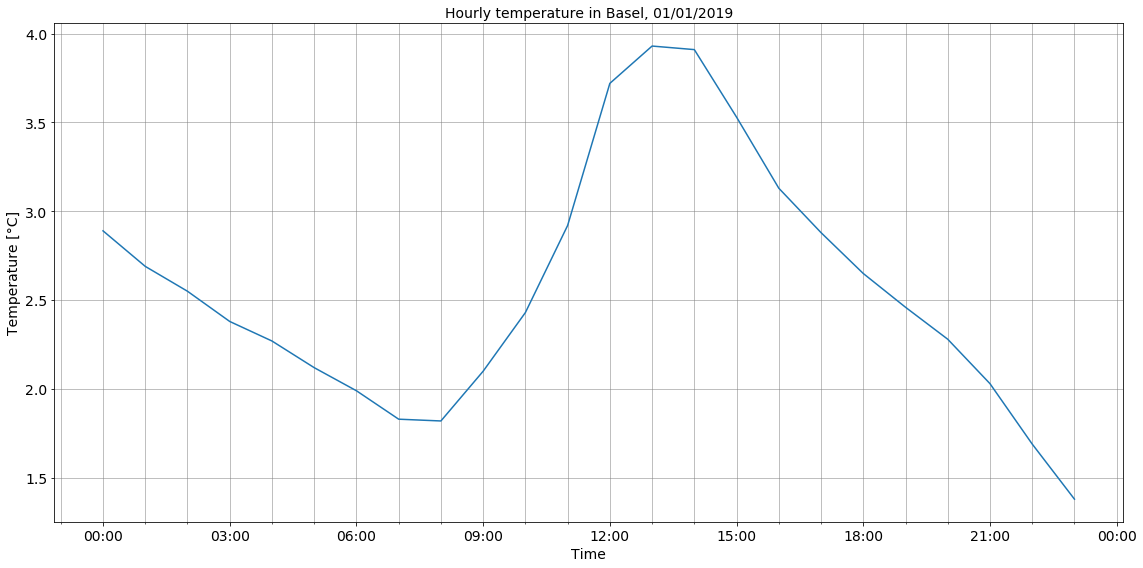

In [7]:
labels_size = 14

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:00'))
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval = 1))
plt.plot(time_temp,  data_temp)
plt.xlabel('Time', size=labels_size)
plt.ylabel("Temperature [°C]", size=labels_size)
plt.xticks(fontsize=labels_size, rotation=0)
plt.yticks(fontsize=labels_size)
plt.grid(which='both', color='grey', linestyle='-', linewidth=0.5)
plt.gcf().set_size_inches(16, 8)
plt.title('Hourly temperature in Basel, 01/01/2019', size=labels_size, loc='center')
plt.tight_layout()
plt.show()
plt.close()

## 2.2 Retrieving temperatures for a selected area

We want to visualize how temperatures were distributed on 01/01/2019 over the Alps and compare 3 weather models with different spatial resolution: 30, 12 and 4 km.

First of all, we now have to define a [polygon](https://docs.meteoblue.com/en/apis/environmental-data/dataset-api#polygon-and-multipolygon) covering our area of interest. Again this can be easily done graphically in the web interface. Alternatively, it can be supplied using a list of tuples.   
NOTE: The first and last coordinate must be the same. Make sure to supply a valid polygon without self-intersections.   

Since we want a daily value of temperature, we also have to specify how we want to aggregate the hourly data to generate a daily value. In this case, we choose the minimum daily value. Other available aggregations are the maximum and the mean.

In [8]:
async def queryFunction(domain):
    
    query = {
        "units": {
            "temperature": "C",
            "velocity": "km/h",
            "length": "metric",
            "energy": "watts"
        },
        "geometry": {
            "type": "Polygon",
            "coordinates": [
                [
                    [
                        6.761378,
                        45.405712
                    ],
                    [
                        6.761378,
                        47.504448
                    ],
                    [
                        12.4618,
                        47.504448
                    ],
                    [
                        12.4618,
                        45.405712
                    ],
                    [
                        6.761378,
                        45.405712
                    ]
                ]
            ]
        },
        "format": "protobuf",
        "timeIntervals": [
            "2019-01-01T+00:00/2019-01-01T+00:00"
        ],
        "timeIntervalsAlignment": None,
        "queries": [
            {
                "domain": domain,  # we are going to test 3 different ones: NEMSGLOBAL, NEMS12 and NEMS4
                "gapFillDomain": None,
                "timeResolution": "daily",  # we now want to retrieve the daily value
                "codes": [
                    {
                        "code": 11,
                        "level": "2 m above gnd",
                        "aggregation": "min"  # in this case, we are interested in the minimum daily value
                    }
                ]
            }
        ]
    }
    client = meteoblue_dataset_sdk.Client(apikey=yourApiKey)
    result = await client.query(query)
    return result


In cases of multiple large queries like this, it is recommended to parallelize them to minimize the run time.   
meteoblue dataset SDK allows asynchronous IO to maximize efficiency: just split large queries into tasks that can be awaited.

In [9]:
task_nems30 = asyncio.create_task(queryFunction("NEMSGLOBAL"))
task_nems12 = asyncio.create_task(queryFunction("NEMS12"))
task_nems4 = asyncio.create_task(queryFunction("NEMS4"))
result_nems30 = await task_nems30
result_nems12 = await task_nems12
result_nems4 = await task_nems4

results = [result_nems30.geometries[0], result_nems12.geometries[0], result_nems4.geometries[0]]

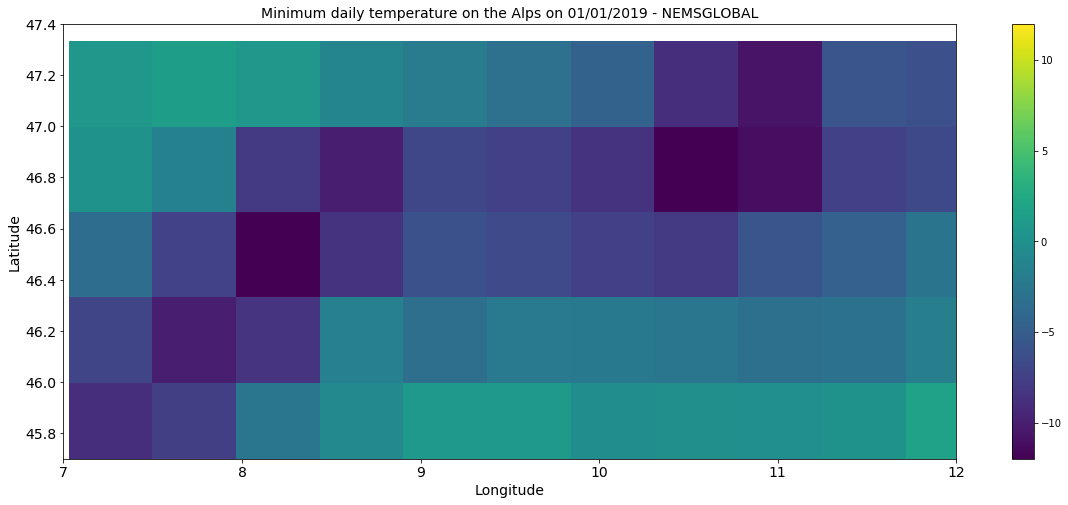

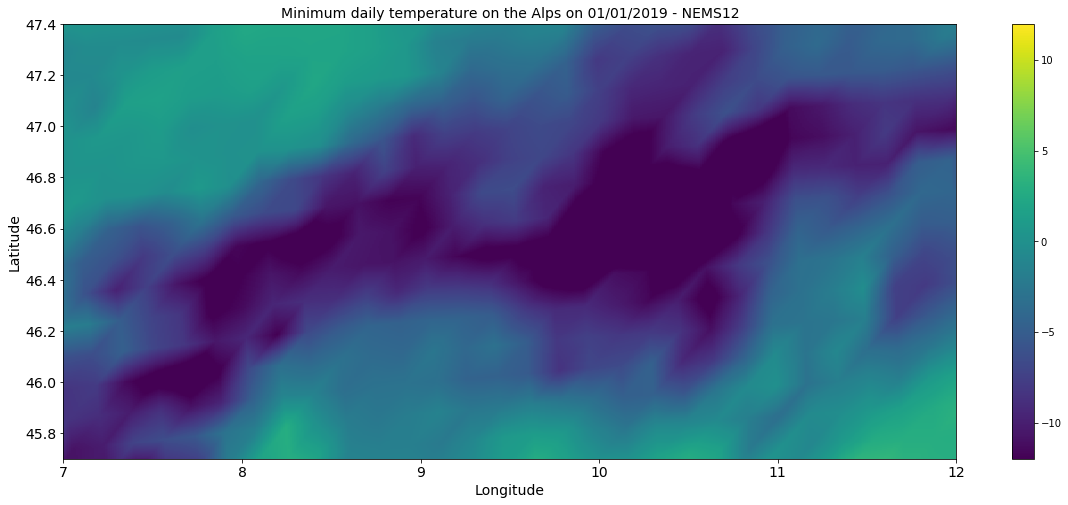

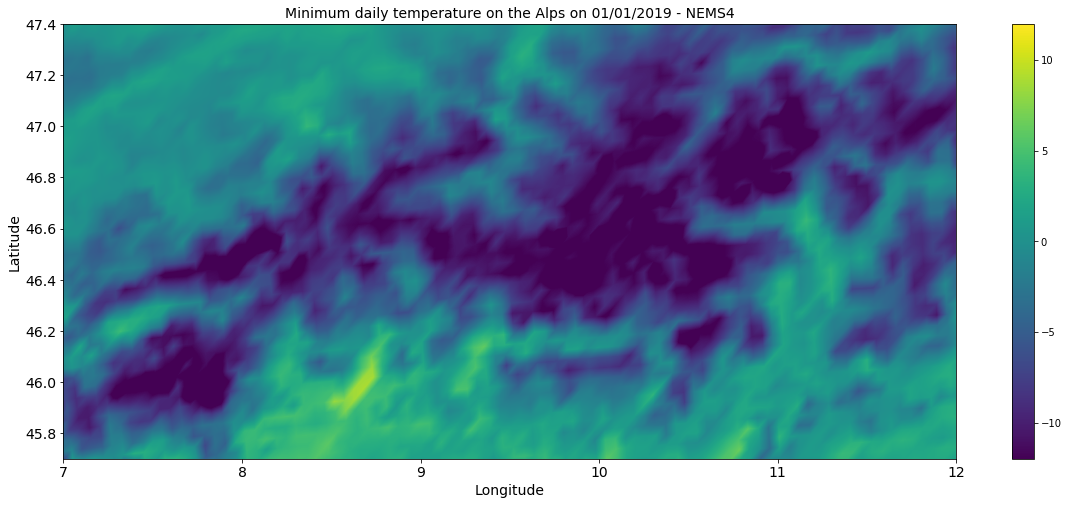

In [12]:
labels_size = 14
for m in range(len(results)):
    x = results[m].lons
    y = results[m].lats
    data_temp = results[m].codes[0].timeIntervals[0].data
    domain = results[m].domain
    xu = np.linspace(min(x), max(x), len(set(x)))
    yu = np.linspace(min(y), max(y), len(set(y)))

    X,Y = np.meshgrid(xu, yu)

    # Interpolate (x,y,z) points over a normal (x,y) grid [X,Y]
    Z = griddata((x, y), data_temp, (X,Y), 'linear')

    plt.pcolormesh(X,Y,Z, vmin=-12, vmax=12)
    plt.ylim(45.7,47.4)
    plt.xlim(7,12)
    plt.xlabel('Longitude', size=labels_size)
    plt.ylabel("Latitude", size=labels_size)
    plt.xticks(fontsize=labels_size, rotation=0)
    plt.yticks(fontsize=labels_size)
    plt.gcf().set_size_inches(20, 8)
    plt.title('Minimum daily temperature on the Alps on 01/01/2019 - '+domain, size=labels_size, loc='center')
    plt.colorbar()
    plt.show()
    plt.close()

Let's now imagine we want to know where the minimum daily temperature was below the frost threshold of 0 °C.   
Of course we could mask in our code the array of temperatures generated before, but it is also possible to perform this operation directly in the API query, by defining a [transformation](https://docs.meteoblue.com/en/apis/environmental-data/dataset-api#transformations).   
They are a powerful tool and can be again easily configured from the web interface.

In [13]:
async def queryFunction(domain):
    
    query = {
        "units": {
            "temperature": "C",
            "velocity": "km/h",
            "length": "metric",
            "energy": "watts"
        },
        "geometry": {
            "type": "Polygon",
            "coordinates": [
                [
                    [
                        6.761378,
                        45.405712
                    ],
                    [
                        6.761378,
                        47.504448
                    ],
                    [
                        12.4618,
                        47.504448
                    ],
                    [
                        12.4618,
                        45.405712
                    ],
                    [
                        6.761378,
                        45.405712
                    ]
                ]
            ]
        },
        "format": "protobuf",
        "timeIntervals": [
            "2019-01-01T+00:00/2019-01-01T+00:00"
        ],
        "timeIntervalsAlignment": None,
        "queries": [
            {
                "domain": domain,
                "gapFillDomain": None,
                "timeResolution": "daily",
                "codes": [
                    {
                        "code": 11,
                        "level": "2 m above gnd",
                        "aggregation": "min"
                    }
                ],
                "transformations": [
                    {
                        "type": "maskOut",
                        "aboveOrBelow": "greaterThanEquals",
                        "threshold": 0,
                        "dataQuery": {
                            "domain": domain,
                            "gapFillDomain": None,
                            "timeResolution": "daily",
                            "codes": [
                                {
                                    "code": 11,
                                    "level": "2 m above gnd",
                                    "aggregation": "min"
                                }
                            ]
                        }
                    }
                ]
            }
        ]
    }
    client = meteoblue_dataset_sdk.Client(apikey=yourApiKey)
    result = await client.query(query)
    return result


In [14]:
result_nems4 = await queryFunction("NEMS4")

results = [result_nems4.geometries[0]]

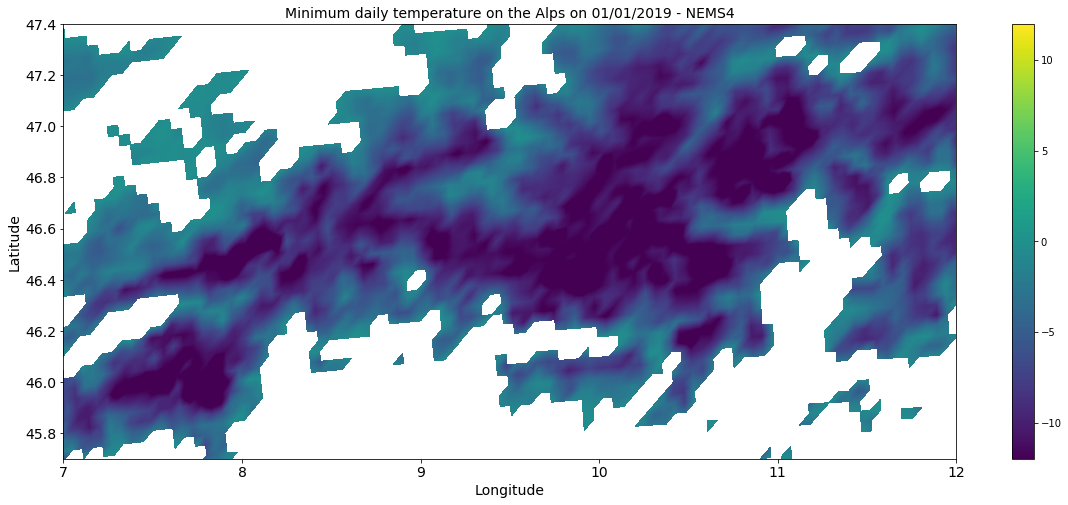

In [15]:
labels_size = 14
for m in range(len(results)):
    x = results[m].lons
    y = results[m].lats
    data_temp = results[m].codes[0].timeIntervals[0].data
    domain = results[m].domain
    xu = np.linspace(min(x), max(x), len(set(x)))
    yu = np.linspace(min(y), max(y), len(set(y)))

    X,Y = np.meshgrid(xu, yu)

    # Interpolate (x,y,z) points over a normal (x,y) grid [X,Y]
    Z = griddata((x, y), data_temp, (X,Y), 'linear')

    plt.pcolormesh(X,Y,Z, vmin=-12, vmax=12)
    plt.ylim(45.7,47.4)
    plt.xlim(7,12)
    plt.xlabel('Longitude', size=labels_size)
    plt.ylabel("Latitude", size=labels_size)
    plt.xticks(fontsize=labels_size, rotation=0)
    plt.yticks(fontsize=labels_size)
    plt.gcf().set_size_inches(20, 8)
    plt.title('Minimum daily temperature on the Alps on 01/01/2019 - '+domain, size=labels_size, loc='center')
    plt.colorbar()
    plt.show()
    plt.close()

## 2.3 Compare yearly precipitation in a selected area averaged over two different periods

Let's now analyze how the average yearly precipitation amount changed over years over South America.   
We want for example to compare the average yearly precipitation of 1985-1994 to the average of the last 10 years 2010-2019.

Political areas like continents, countries or regions in the web-interfaces are based on the [geonames](https://docs.meteoblue.com/en/apis/environmental-data/dataset-api#geoname-polygon) polygon database: to keep queries short and not always include the full GeoJSON polygon for each administrative area, the API can directly get a polygon from a database. Once the polygon is loaded from the database, the behavior is identical to a regular polygon query.   

Multiple time intervals can be selected by simply listing them.   

In this case, though, we cannot use the 10 km resolution NEMSSA as weather model, because it is only available after 2008. Our choice is therefore NEMSGLOBAL.

In [16]:
def dataArray(data: list):
    dataList = []
    for i in range(len(data)):
        data_i = data[i].data
        dataList.append(data_i)
    dataArray = np.array(dataList)
    return dataArray

In [17]:
async def queryFunction():
    
    query = {
        "units": {
            "temperature": "C",
            "velocity": "km/h",
            "length": "metric",
            "energy": "watts"
        },
        "geometry": {
            "type": "GeonamePolygon",  # administrative areas can be selected using geonames (see web interface)
            "geonameid": 6255150
        },
        "format": "protobuf",
        "timeIntervals": [  # multiple time intervals are simply listed
            "1985-01-01T+00:00/1995-01-01T+00:00",
            "2010-01-01T+00:00/2020-01-01T+00:00"
        ],
        "timeIntervalsAlignment": None,
        "queries": [
            {
                "domain": "NEMSGLOBAL",
                "gapFillDomain": None,
                "timeResolution": "daily",
                "codes": [
                    {
                        "code": 61,  # precipitation
                        "level": "sfc",  # precipitation can only be at surface
                        "aggregation": "sum"  # precipitation has only one possible aggregation: sum
                    }
                ],
                "transformations": [  # More than one transformation can be specified. All transformations are processed one after another
                    {
                        "type": "aggregateYearly",
                        "aggregation": "sum"
                    },
                    {
                        "type": "aggregateTimeInterval",
                        "aggregation": "mean"
                    }
                ]
            }
        ]
    }
    client = meteoblue_dataset_sdk.Client(apikey=yourApiKey)
    result = await client.query(query)
    return result

In [18]:
# this will take some time... but we now know it could be split into tasks and parallelized!

resultProtobuf_prec = await queryFunction()

results = resultProtobuf_prec.geometries[0]
lats_prec = results.lats
lons_prec = results.lons
data_prec = dataArray(results.codes[0].timeIntervals)

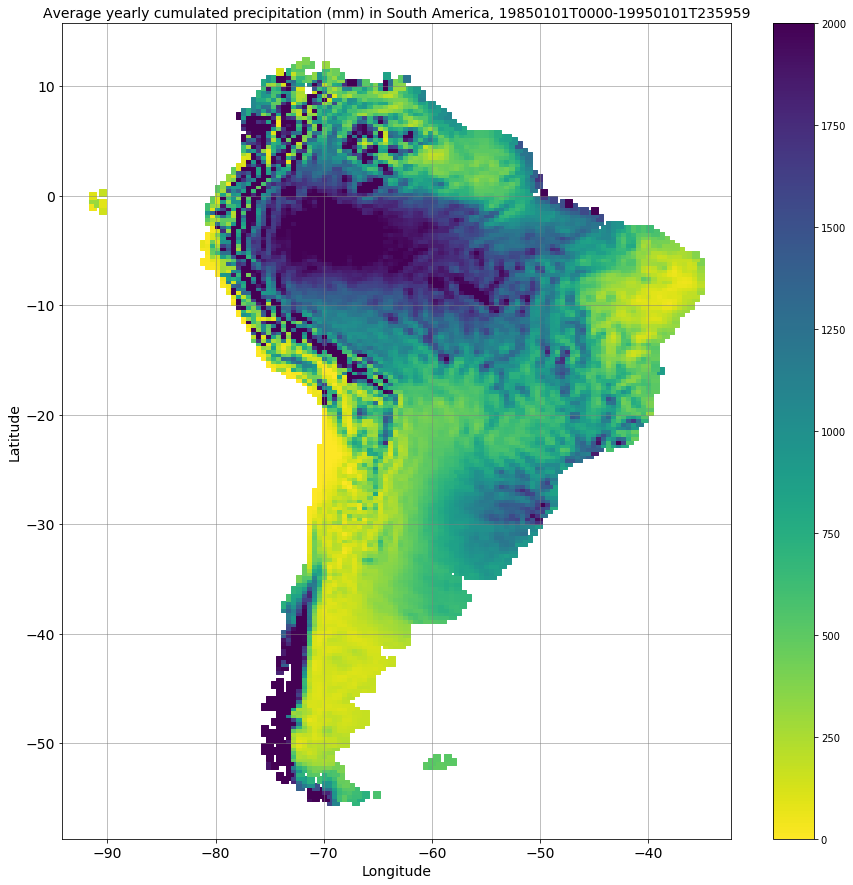

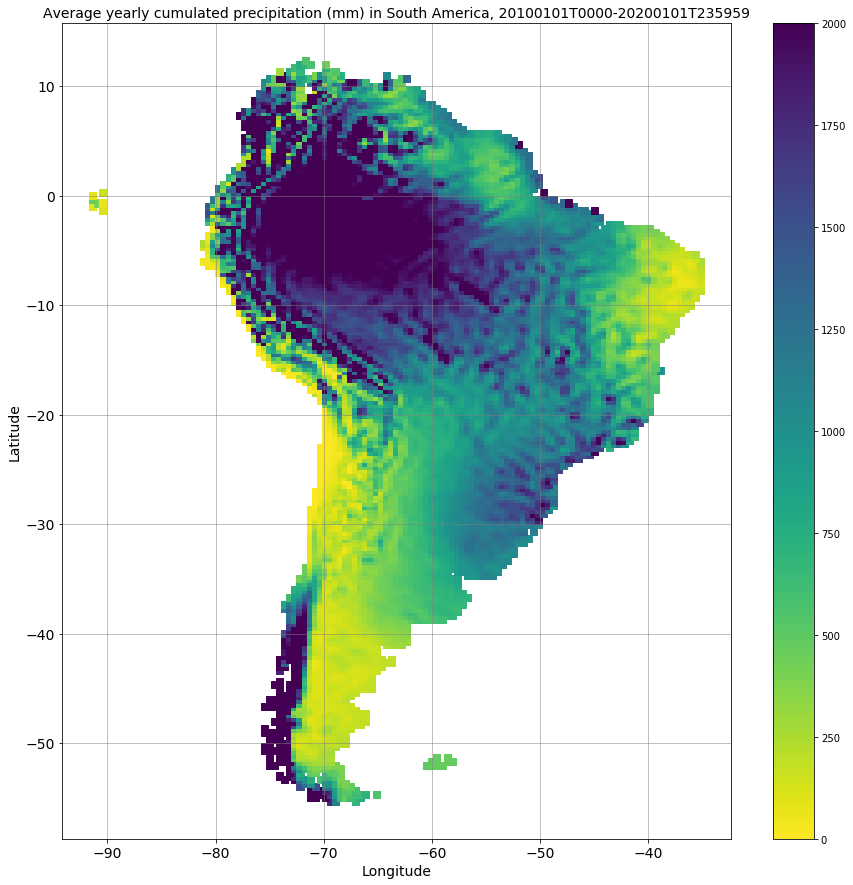

In [19]:
labels_size = 14

for t in range(len(data_prec)):
    plt.scatter(lons_prec, lats_prec, c=data_prec[t], cmap='viridis_r', marker="s", s=50, vmin=0, vmax=2000)
    plt.colorbar()
    plt.xlabel('Longitude', size=labels_size)
    plt.ylabel("Latitude", size=labels_size)
    plt.xticks(fontsize=labels_size, rotation=0)
    plt.yticks(fontsize=labels_size)
    plt.grid(which='both', color='grey', linestyle='-', linewidth=0.5)
    plt.gcf().set_size_inches(15, 15)
    plt.title('Average yearly cumulated precipitation (mm) in South America, '+results.timeIntervals[t].timestrings[0], size=labels_size, loc='center')
    plt.show()
    plt.close()